# Project Title (w/ header below)

## Sources
This project makes use of information from the following sources:
  
* Dr. Sprint's [CPSC 222 Course Materials](https://github.com/GonzagaCPSC222)

* Python Standard Library [Documentation Pages](https://docs.python.org/3/library/)

* Pandas [Documentation Pages](https://pandas.pydata.org/docs/)

* [Python Basics](https://pythonbasics.org/)

* MatPlotLib [Documention Pages](https://matplotlib.org/)

Links to specific pages are included throughout as they are relavent.

## Introduction

## Data Preperation
The Fitbit website allows access to personal data in a very friendly format. I have access to both my sleep and activity data gathered by my device from September 17, 2020 to the present. Looking at the data using Microsoft Excel, I can see that every entry is a numerical value, except for the date and time stamps. A few of the columns will also have to be converted from strings to integers due to the prescence of commas. The activity CSV has one date column for which every other attribute has a corresponding value. The sleep CSV meanwhile, has two timestamps columns: one for the sleep start time and one for the sleep stop time. That will be my main task in preparing the data. 
### Cleaning (Spreadsheet)
Looking at both CSV files in Microsoft Excel, I can see that both top rows contain one cell that has the label for the data table.  
<img src="https://github.com/lmartin5/CPSC_222_Quantified_Self_Project/blob/master/figures/data_with_label_row.PNG?raw=true"  width="700"/>  
Since this is a one-step process, for both CSV files I manually deleted the top row, so that now the top row only contains the column labels.  
<img src="https://github.com/lmartin5/CPSC_222_Quantified_Self_Project/blob/master/figures/data_without_label_row.PNG?raw=true"  width="700"/>

### File Organization
To keep this project organized, I am going to keep all of my data files in one folder, so I need to be able to access files from the folder to read in and write data. To do this and have the path code work on all of the main operating systems, I am going to use the Python `OS` module and its [`path.join()`](https://docs.python.org/3/library/os.path.html) function. The first file I am accessing is the two CSV files that contain my sleep and activity data.

In [1]:
import os

sleep_data_path = os.path.join("files", "fitbit_sleep_data.csv")
activity_data_path = os.path.join("files", "fitbit_activity_data.csv")

### Loading the Data
`Pandas` will be the main module used for working directly with the data, and the `read_csv()` function can be used to load the data directly. The `index_col` key word in the `read_csv()` function can be set to 0 when loading in the activity data because it already has the date in a usable format. More work will have to be done using the time stamps in the sleep data to get a identical index column. The `set_option()` function is used to force the program to display all of the columns of the DataFrame as discussed [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html).

In [2]:
import pandas as pd

sleep_df = pd.read_csv(sleep_data_path)
activity_df = pd.read_csv(activity_data_path, index_col=0)
pd.set_option("display.max_columns", None)

There are three columns in the sleep DataFrame that only contain NaN values. These are attributes that are tracked by devices more advanced than the one used in this project, so they can be droped from the DataFrame. I will also change the column labels so that the DataFrames can print out in a more friendly format in the report. 

In [3]:
sleep_df.drop(["Minutes REM Sleep", "Minutes Light Sleep", "Minutes Deep Sleep"], axis=1, inplace=True)
sleep_df.columns = ["Start", "End", "Asleep", "Awake", "Times Awake", "Time in Bed"]
activity_df.columns = ["Cals", "Steps", "Distance", "Floors", "MS", "MLA", "MFA", "MVA", "Act. Cals"]

print("Sleep Data")
print(sleep_df.head())
print()
print("Activity Data")
print(activity_df.head())

Sleep Data
                Start                 End  Asleep  Awake  Times Awake  \
0  2020-12-16 12:43AM   2020-12-16 7:06AM     374      9            0   
1  2020-12-14 10:57PM   2020-12-15 8:49AM     576     15            0   
2  2020-12-13 11:10PM   2020-12-14 7:46AM     497     19            1   
3   2020-12-13 1:27AM  2020-12-13 10:18AM     506     25            0   
4  2020-12-11 11:56PM   2020-12-12 7:15AM     385     54            3   

   Time in Bed  
0          383  
1          592  
2          516  
3          531  
4          438  

Activity Data
            Cals   Steps  Distance  Floors     MS  MLA  MFA  MVA Act. Cals
Date                                                                      
9/17/2020  1,904     353      0.17       0  1,407   33    0    0       128
9/18/2020  3,125  11,504      5.55       5    647  295   39   31     1,666
9/19/2020  2,338   3,463      1.67       2    720  147    0    0       577
9/20/2020  2,777   8,782      4.23       5    528  210   2

### Type Conversion
Right now, there are a few columns in the activity DataFrame that hold strings instead of integers due to commas. I wrote a function to deal with these commas, and it can be used on the columns that are currently strings.

In [4]:
def clean_column(column):
    '''
    Cleans a column that contains strings of integer values with commas
    Parameter column: a Pandas Series from a DataFrame
    Returns: a Series with the same data but of type int
    '''
    col_copy = column.copy()
    for i in col_copy.index:
        str_copy = col_copy[i]
        str_copy = str_copy.replace(",", "")
        col_copy[i] = str_copy
    col_copy = col_copy.astype(int)
    return col_copy

activity_df["Cals"] = clean_column(activity_df["Cals"])
activity_df["Steps"] = clean_column(activity_df["Steps"])
activity_df["MS"] = clean_column(activity_df["MS"])
activity_df["Act. Cals"] = clean_column(activity_df["Act. Cals"])

I can confirm now that every column consists of numerical data using the DataFrame `dtypes` attribute.

In [5]:
print(sleep_df.dtypes)
print(activity_df.dtypes)

Start          object
End            object
Asleep          int64
Awake           int64
Times Awake     int64
Time in Bed     int64
dtype: object
Cals           int32
Steps          int32
Distance     float64
Floors         int64
MS             int32
MLA            int64
MFA            int64
MVA            int64
Act. Cals      int32
dtype: object


### Manipulating Time Stamps
I want the instances of the activity DataFrame and the instances of the sleep DataFrame to line up so that I can compare them. For this project, I want to compare my sleep data for each day to my activity data for the day preceding the sleep. First, I need to get just the desired date from the time stamps, and then get rid of the two time stamp columns. Because I sometimes went to sleep before midnight and sometimes after midnight, I need to only use the "End Time" column. The dash characters need to be [replaced](https://pythonbasics.org/replace/) with forward slash charcters just like in the activity DataFrame. After that, I have to [sort](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_index.html) the order of the sleep DataFrame so that it is in ascending chronological order similar to the activity DataFrame. I am going to have to also shift the dates over one day, so that the first data point in the activity data lines up with the first data point in the sleep data; the first index for each should be September 17, 2020.

In [6]:
index = sleep_df["End"].copy() 
sleep_df.drop(["Start", "End"], axis=1, inplace=True)
index_len = len(index)
for i in range(index_len):
    str_copy = index[i]
    str_copy = str_copy[0:10] # retrieves the first 10 characters, which is the date format
    str_copy = str_copy.replace("-", "/")
    index[i] = str_copy
index.name = "Date"
sleep_df.index = index
sleep_df.sort_index(inplace=True) # reverses the order of the DataFrame
# Now that both DataFrames are in the same order, I can make them have identical indices
sleep_df.index = activity_df.index
print(sleep_df.tail(30))

            Asleep  Awake  Times Awake  Time in Bed
Date                                               
11/16/2020     378     24            1          406
11/17/2020     398     28            1          426
11/18/2020     422     14            2          444
11/19/2020     383     14            3          401
11/20/2020     561     31            1          592
11/21/2020     519     32            0          551
11/22/2020     417     17            0          436
11/23/2020     408     23            1          433
11/24/2020     396     18            0          414
11/25/2020     596     19            1          615
11/26/2020     692     21            1          719
11/27/2020     528     18            0          547
11/28/2020     602     19            1          621
11/29/2020     498     53            3          551
11/30/2020     395      4            0          399
12/1/2020      422     20            2          442
12/2/2020      519     22            1          541
12/3/2020   

To confirm that both DataFrames are now indexed the way that I want them, I will look at a random date: October 1st. I want the 10/1/2020 activity data to line up with the amount of sleep when I woke up on October 2nd. Looking at the above sleep DataFrame, I can see that at the index 10/01/2020 there are values of 384, 3, 0, and 387. I have confirmed that these are the same numbers in the sleep CSV file that correspond with the instance where I woke up on October 2nd. I now have the data in a format where I can directly compare them.

### Data Merging
The last thing to do in data preperation is to [join](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) the data into one DataFrame. I am also exporting the data to a CSV file so it can be saved and referenced during the project.

In [7]:
cleaned_data_path = os.path.join("files", "fitbit_data_cleaned.csv")

sleep_activity_df = activity_df.join(sleep_df)
print(sleep_activity_df.head())
sleep_activity_df.to_csv(cleaned_data_path)

           Cals  Steps  Distance  Floors    MS  MLA  MFA  MVA  Act. Cals  \
Date                                                                       
9/17/2020  1904    353      0.17       0  1407   33    0    0        128   
9/18/2020  3125  11504      5.55       5   647  295   39   31       1666   
9/19/2020  2338   3463      1.67       2   720  147    0    0        577   
9/20/2020  2777   8782      4.23       5   528  210   24   32       1230   
9/21/2020  3663  17612      8.49      26   596  267  118   47       2284   

           Asleep  Awake  Times Awake  Time in Bed  
Date                                                
9/17/2020     404     24            1          428  
9/18/2020     526     47            3          573  
9/19/2020     585     10            0          596  
9/20/2020     430     29            1          462  
9/21/2020     388      7            0          396  


## Instance Labeling
In order to use the `groupby()` function, I need the instances to have labels that can be grouped together. For this project, I will add a column that stores the month, sleep quality, and exercise amount for each instance.

### Month Label
For the month label, I created the label based upon the date in the index column. Using a `for` loop, I filled a Pandas Series with the month for that instance.

In [8]:
Month = pd.Series(dtype=str)
for date in sleep_activity_df.index:
    date_copy = date.replace("/", "")
    if date_copy[0] is '9':
        Month[date] = "Sept"
    else:
        # for single digit day of the month numbers
        if len(str(date_copy)) is 7:
            date_copy = int(date_copy) // 100000
        # for double digit day of the month numbers
        elif len(str(date_copy)) is 8:
            date_copy = int(date_copy) // 1000000
        if date_copy is 10:
            Month[date] = "Oct"
        if date_copy is 11:
            Month[date] = "Nov"
        if date_copy is 12:
            Month[date] = "Dec"
sleep_activity_df["Month"] = Month

### Sleep Quality Label
Sleep quality is the most important label in my data set. It will be used with a kNN classifier to predict what kind of sleep I might get based upon the exercise I have in the day preceeding. I have to invent a unique metric to determine what kind of sleep I got in a certain night. It will not be a perfect, qualatative measurement, but it will allow me to use classification on this data set. The first thing I will do is get an idea of the spread of my sleep data. For me personally, the time I spend awake while in bed is the biggest teller of sleep quality. A lesser amount of time spent awake when I am trying to go to sleep usually indicates better sleep for myself. I created [histograms](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html) using the `matplotlib` module to get a initial exposure to the data. 

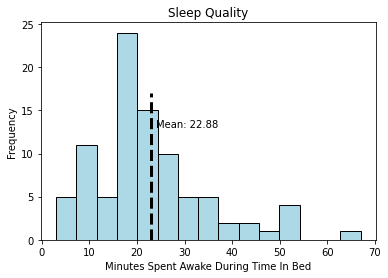

In [9]:
import matplotlib.pyplot as plt
import numpy as np # used for mean

x = sleep_activity_df["Awake"].copy().values
x_mean = np.mean(x)
plt.figure()
plt.hist(x, bins=15, color="#add8e6", edgecolor="black")
plt.plot([x_mean, x_mean], [0, 17], ls="dashed", color="black", lw=3)
plt.axis("tight")
plt.annotate("Mean: %.2f" %(x_mean), xy=(24,13), color="black")
plt.title("Sleep Quality")
plt.ylabel("Frequency")
plt.xlabel("Minutes Spent Awake During Time In Bed")
plt.show()
plt.close()

It looks like the data is somewhat normally distributed, although it shows signs of being right-skewed. These could be data points where I was in bed for much longer than usual, such as on the weekend. To see if I can mitigate this result, I will create an attribute that is the percentage of time in bed spent awake (Awake / Time in Bed). I used the `numpy` module to use vectorized operations on nd-arrays.

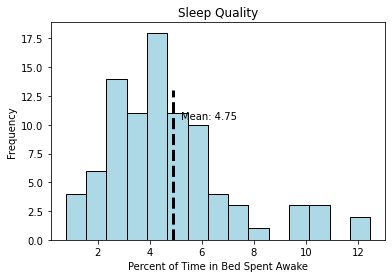

In [10]:
min_awake = np.array(sleep_activity_df["Awake"].copy().values)
min_in_bed = np.array(sleep_activity_df["Time in Bed"].copy().values)
percent_awake = (min_awake / min_in_bed) * 100
sleep_activity_df["% Awake"] = percent_awake
sleep_activity_df.to_csv(cleaned_data_path) # updating csv file

# creating histogram
x = sleep_activity_df["% Awake"].copy().values
x_mean = np.mean(x)
plt.figure()
plt.hist(x, bins=15, color="#add8e6", edgecolor="black")
plt.plot([x_mean + 0.15, x_mean + 0.15], [0, 13], ls="dashed", color="black", lw=3)
plt.axis("tight")
plt.annotate("Mean: %.2f" %(x_mean), xy=(5.2,10.5), color="black")
plt.title("Sleep Quality")
plt.ylabel("Frequency")
plt.xlabel("Percent of Time in Bed Spent Awake")
plt.show()
plt.close()

The "% Awake" attribute is more normally distributed, and it does account for the differing amounts of time spent in bed. Since the "Times Awake" attribute only contains values 0 through 3, I used the "% Awake" attribute to classify my sleep quality, as I think it is the most telling out of all the attributes. I am going to categorize each night of sleep into one of four categories: heavily disrupted, moderately disrupted, moderately restful, and restful. I split the values into the categories roughly using the four quartiles of the data, as seen in the [box plot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.boxplot.html) below.

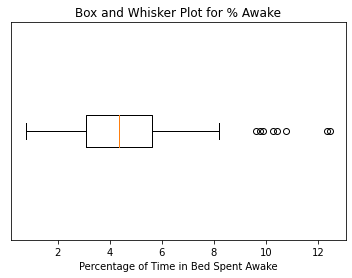

In [11]:
plt.figure
plt.boxplot(percent_awake, vert=False)
plt.yticks([])
plt.title("Box and Whisker Plot for % Awake")
plt.xlabel("Percentage of Time in Bed Spent Awake")
plt.show()
plt.close()

In [12]:
sleep_quality = pd.Series(dtype=str)

percent_awake = sleep_activity_df["% Awake"].copy()
percent_awake = percent_awake.sort_values()
index = percent_awake.index
x_len = len(percent_awake)

for i in range(x_len):
    date = index[i]
    if date[0] is "9":
        date = "0" + date
    elif len(date) is 9 and date[0] is not "9": # puts 0 in fron of single digit days for sorting (10/1 to 10/01)
        date = date[:3] + "0" + date[3:]
    if i >= 0 and i < x_len // 4: # the first quarter of data
        sleep_quality[date] = "restful"
    elif i >= x_len // 4 and i < 2*(x_len // 4): # the second quarter of data
        sleep_quality[date] = "moderately restful"
    elif i >= 2*(x_len // 4) and i < 3*(x_len // 4): # the third quarter of data
        sleep_quality[date] = "moderately disrupted"
    elif i >= 3*(x_len // 4) and i < x_len: # the fourth quarter of data
        sleep_quality[date] = "heavily disrupted"
sleep_quality.sort_index(inplace=True)
sleep_quality.index = sleep_activity_df.index # changing index back to original format
sleep_activity_df["Sleep Quality"] = sleep_quality

### Exercise Amount Label
This label is only used during the hypothesis testing section of the project. Once I have distinct labels categorizing the exercise I got during a day, I can use the `groupby()` function to seperate out each of these data points. I can then use hypothesis testing to see if there is a difference in the sleep I get during the days where I have little to no exercise and the sleep I get during the days where I get a high amount of exercise.

The activity calories (Act. Cals) was the most ideal attribute to categorize my exercise amount. Unlike the minutes attributes, activity calories represents how much exercise I got in a day. Again, the category label will not be perfect, but it will allow for some interesting grouping of data. 

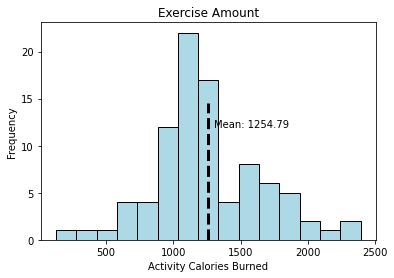

In [13]:
x = sleep_activity_df["Act. Cals"].copy().values
x_mean = np.mean(x)
plt.figure()
plt.hist(x, bins=15, color="#add8e6", edgecolor="black")
plt.plot([x_mean, x_mean], [0, 14.5], ls="dashed", color="black", lw=3)
plt.axis("tight")
plt.annotate("Mean: %.2f" %(x_mean), xy=(1300,12), color="black")
plt.title("Exercise Amount")
plt.ylabel("Frequency")
plt.xlabel("Activity Calories Burned")
plt.show()
plt.close()

This data is somewhat normally distributed, so it will be good to use t-tests with later on. I also categorized each day in a similar way as the sleep data, using the quartiles. There are four categories: inactive, lightly active, fairly active, and highly active. These categories are not to be confused with the attribute labels of similar names. 

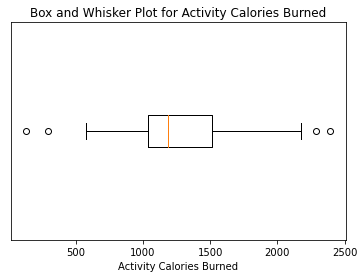

In [14]:
plt.figure
plt.boxplot(sleep_activity_df["Act. Cals"].values, vert=False)
plt.yticks([])
plt.title("Box and Whisker Plot for Activity Calories Burned")
plt.xlabel("Activity Calories Burned")
plt.show()
plt.close()

In [15]:
exercise_amount = pd.Series(dtype=str)

act_calories = sleep_activity_df["Act. Cals"].copy()
act_calories = act_calories.sort_values()
index = act_calories.index
x_len = len(act_calories)

for i in range(x_len):
    date = index[i]
    if date[0] is "9":
        date = "0" + date
    elif len(date) is 9 and date[0] is not "9": # puts 0 in fron of single digit days for sorting (10/1 to 10/01)
        date = date[:3] + "0" + date[3:]
    if i >= 0 and i < x_len // 4: # the first quarter of data
        exercise_amount[date] = "inactive"
    elif i >= x_len // 4 and i < 2*(x_len // 4): # the second quarter of data
        exercise_amount[date] = "lightly active"
    elif i >= 2*(x_len // 4) and i < 3*(x_len // 4): # the third quarter of data
        exercise_amount[date] = "fairly active"
    elif i >= 3*(x_len // 4) and i < x_len: # the fourth quarter of data
        exercise_amount[date] = "highly active"
exercise_amount.sort_index(inplace=True)
exercise_amount.index = sleep_activity_df.index # changing index back to original format
sleep_activity_df["Exercise Amount"] = exercise_amount

# writing labels data to csv file for reference
labels_path = os.path.join("files", "data_labels.csv")
sleep_activity_df[["Exercise Amount", "Sleep Quality"]].to_csv(labels_path)

## Exploratory Data Analysis and Visualizations

## Hypothesis Testing

In [16]:
import scipy.stats as stats
grouped_by_exercise = sleep_activity_df.groupby("Exercise Amount")

t_computed, p_value = stats.ttest_ind(grouped_by_exercise.get_group("inactive")["% Awake"].values, grouped_by_exercise.get_group("highly active")["% Awake"].values)
print(t_computed, p_value)

0.9427627173497284 0.35095019616430734


## Classification

## Conclusion